# Modeling Choices

This notebook serves as an explanation of how rays are computed through the input files.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path().cwd().parent
sys.path.append(str(PROJECT_ROOT))

image_path = PROJECT_ROOT / 'ReMIND2Reg_dataset' / 'imagesTr'

from src.utils import *
from src.impedance import *
from src.datatype import MRIDataset, iUSDataset
from src.renderer import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import torch.nn.functional as F
from sklearn.cluster import KMeans

c:\Users\noe\anaconda3\envs\torchIO\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
patient_id = "005" # between 000 and 102, t1 and t2 don't exist for all patients
iUS_file = f"ReMIND2Reg_0{patient_id}_0000.nii.gz"
t1_file = f"ReMIND2Reg_0{patient_id}_0001.nii.gz"
t2_file = f"ReMIND2Reg_0{patient_id}_0002.nii.gz"
# dataset = MRIDataset([image_path / t1_file], "T1", axis=0)

In [4]:
UR = UltrasoundRenderer(128)

In [26]:
def generate_brain_phantom_2d(rows=20, cols=10) -> torch.Tensor:
    brain = 1.60e6
    tumor = 1.68e6
    csf = 1.50e6
    bone = 7.80e6
    air = 0.0004e6

    phantom = torch.full((rows, cols), air)  # default: outside air

    # Make elliptical brain mask
    yy, xx = torch.meshgrid(torch.linspace(-1, 1, rows), torch.linspace(-1, 1, cols), indexing='ij')
    brain_mask = (xx**2 / 0.8**2 + yy**2 / 0.95**2) <= 1.0
    phantom[brain_mask] = brain

    # CSF shell: slightly larger ellipse
    csf_mask = (xx**2 / 0.88**2 + yy**2 / 1.05**2) <= 1.0
    csf_shell = csf_mask & (~brain_mask)
    phantom[csf_shell] = csf

    # Tumor region: center box within brain
    tumor_box = (abs(xx) < 0.2) & (abs(yy) < 0.3)
    phantom[tumor_box & brain_mask] = tumor

    # Add bone at the bottom (last row inside brain)
    brain_row_indices = torch.where(brain_mask.any(dim=1))[0]
    bottom_brain_row = brain_row_indices[-1]
    phantom[bottom_brain_row, brain_mask[bottom_brain_row]] = bone

    return phantom

r_tensor = generate_brain_phantom_2d()

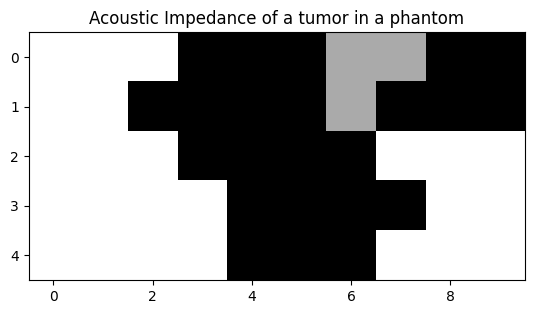

Text(0.5, 1.0, 'Reflection Coefficients of a tumor in a phantom')

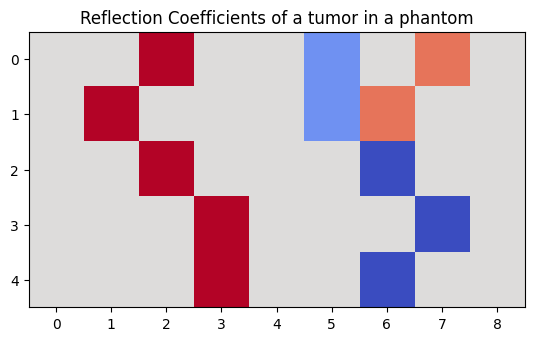

In [27]:
r_tensor = torch.tensor([[1.71e6,1.71e6,1.71e6,1.65e6,1.65e6,1.65e6,1.69e6,1.69e6,1.65e6,1.65e6,], 
                         [1.71e6,1.71e6,1.65e6,1.65e6,1.65e6,1.65e6,1.69e6,1.65e6,1.65e6,1.65e6,],
                         [1.71e6,1.71e6,1.71e6,1.65e6,1.65e6,1.65e6,1.65e6,1.71e6,1.71e6,1.71e6,],
                         [1.71e6,1.71e6,1.71e6,1.71e6,1.65e6,1.65e6,1.65e6,1.65e6,1.71e6,1.71e6],
                         [1.71e6,1.71e6,1.71e6,1.71e6,1.65e6,1.65e6,1.65e6,1.71e6,1.71e6,1.71e6],])

plt.imshow(r_tensor, cmap='gray', interpolation='nearest')
plt.xticks()
plt.yticks()
plt.title("Acoustic Impedance of a tumor in a phantom")
plt.show()
tensor = UR.compute_reflection_coeff(r_tensor[:,1:], r_tensor[:,:-1])
# prop_single_ray(tensor.unsqueeze(0))
plt.imshow(tensor, cmap='coolwarm', interpolation='nearest')
plt.xticks()
plt.yticks()
plt.title("Reflection Coefficients of a tumor in a phantom"
          
          )


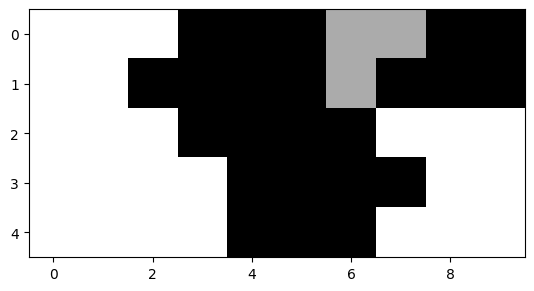

In [28]:
single_prop, _ = compute_echo_traces(tensor)
plt.imshow(single_prop, cmap='gray')
# plt.grid('on')

The plot above gives us a good idea of a mixed medium 2D slice, with a large structure and an inner substructure. This could be a tumor with a necrotic core, or a cyst with a solid part. The reflection coefficients are computed from the acoustic impedance tensor, which is a 2D representation of the medium's properties. The reflection coefficients are then used to compute the echo traces, which represent the reflected ultrasound waves.

However, this is not enough as having the impedance and reflection coefficients only means we know what happens at each stop, not for a global echo. To solve this, we convolve a signal with the resulting echo traces. This allows us to have a more realistic representation of the echo parsing through the membrane and returning to the start point.

The gaussian parameters (length/width) control for the precision of the resulting convolution. A width of 1 makes for the sharpest (voxel-sharp) image, while larger widths will lead to worse results.

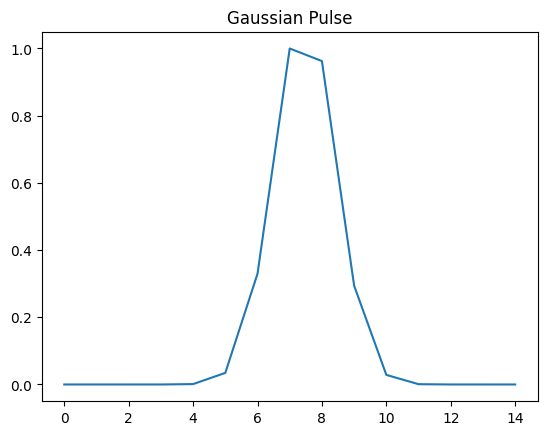

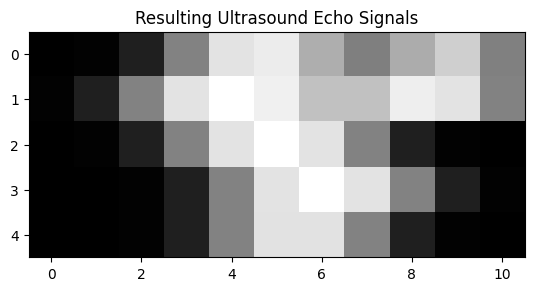

In [30]:
pulse = gaussian_pulse(15, 1)
pulse = torch.tensor(pulse, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
plt.plot(pulse[0, 0].numpy())
plt.title("Gaussian Pulse")
plt.show()
echo_signals = compute_gaussian_pulse(tensor)

plt.imshow(-echo_signals.squeeze(1), cmap='gray')
plt.title("Resulting Ultrasound Echo Signals");

# Recap the results

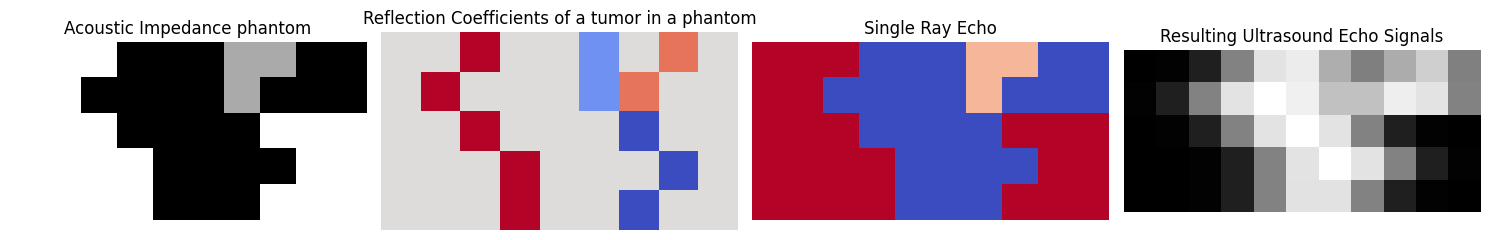

In [31]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))

img_legend = [[r_tensor, "Acoustic Impedance phantom", 'gray'],
              [tensor, "Reflection Coefficients of a tumor in a phantom", 'coolwarm'],
              [single_prop, "Single Ray Echo", 'coolwarm'],
              [-echo_signals.squeeze(1), "Resulting Ultrasound Echo Signals", 'gray']]

for i, (img, title, cmap) in enumerate(img_legend):
    ax[i].imshow(img, cmap=cmap, interpolation='nearest')
    ax[i].set_title(title)
    ax[i].axis('off')

plt.tight_layout()
plt.show()

Some thoughts here: the general issue is that while a _stable_ ray propagation is nicely obtained using our matrix formula, ray propagation consists of invoking a propagated signal. This means that we don't want an stable but a pulse run through. However, rays normally have rebounds contributing to the total echo. This means there is some part of n-th rebounds that conrtibutes to the resulting echo signals. Thus, using the stable results for the echo computation allows to approximate this rebound stability. We then convolce with a gaussian signal to simulate the passthrough of a signal.

# Applying to real MRI

In [33]:
dataset = MRIDataset([image_path / t1_file, image_path / t2_file], "Patient 5", axis=0)

T1 = dataset[0]
T1_volume = T1["image"].squeeze(0)       # (D,H,W)
T2 = dataset[1]
T2_volume = T2["image"].squeeze(0)       # (D,H,W)

T1_volume = T1_volume.float()

T1_data = pd.DataFrame(
    {"organ": ["fat","liver","muscle","BWM","BGM","CSF","AIR"],
     "intensity": [260,500,870,780,920,2500, 0], 
     "impedance": [1.34e6,1.67e6,1.68e6,1.6e6,1.6e6,1.5e6, 0.0004e6]}
)

t1 = T1_data['intensity'].values.reshape(-1,1)
z1 = T1_data['impedance'].values.reshape(-1,1)

X1 = torch.tensor(t1, dtype=torch.float32)
Y1 = torch.tensor(z1, dtype=torch.float32)

model_t1 = ImpedanceEstimator.train_model(X1, Y1, input_dim=1)
Z_vol = ImpedanceEstimator.compute_impedance_volume(T1_volume, model_t1, threshold=50)

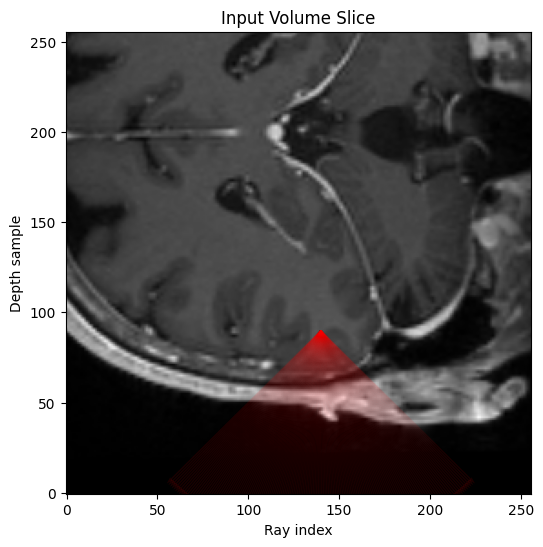

In [ ]:
UR = UltrasoundRenderer(120, 0.0001)

angle = 45  # degrees
rays = 150

thetas = np.radians(np.linspace(-angle,angle, rays))  # 64 rays across the fan
source = np.array([90, 180, 140])  # source position
directions = [np.array([-np.cos(theta), 0, -np.sin(theta)]) for theta in thetas]
directions = torch.tensor(directions, dtype=torch.float32)  # (rays, 3)

img = T1_volume[:, source[1], :].T 

ax = UR.plot_frame(img)

N = directions.shape[0]
starts_x = np.full(N, source[2])  # x coordinate of the source  
starts_y = np.full(N, source[0])  # y coordinate of the source

dx = directions[:, 2]  # previously z becomes new x
dy = directions[:, 0]  # previously x becomes new y

ax.quiver(
    starts_x, starts_y,
    dx, dy,
    angles='xy', scale_units='xy', scale=1/UR.num_samples,
    color='red', width=0.003, alpha=0.1
)


ax.invert_yaxis()


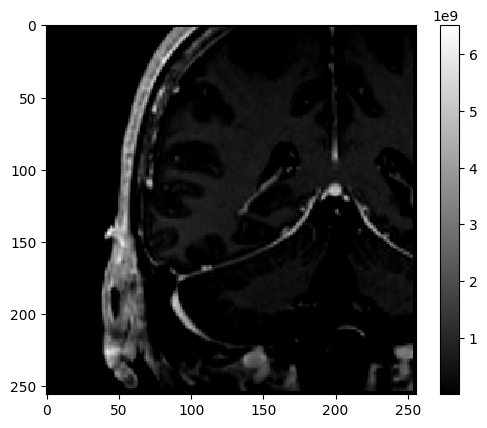

In [35]:
plt.imshow(Z_vol[:, source[1], :].T, cmap='gray', interpolation='nearest')
plt.colorbar()

Intensity range: 0.0000 to 0.2006


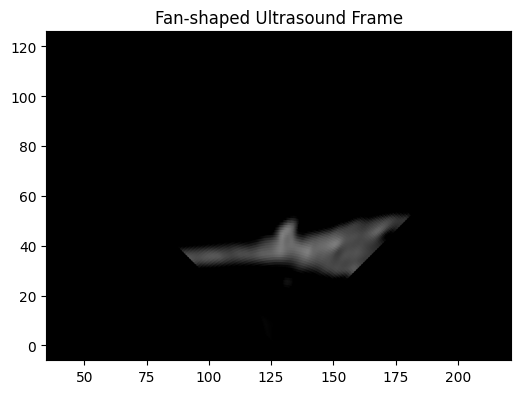

In [39]:
intensities = UR.plot_beam_frame(
    volume=Z_vol,
    source=torch.tensor(source),
    directions=directions,
    artifacts=False,
    angle=angle
)


In [24]:
intensities

tensor([[-0.0005, -0.0012, -0.0022,  ...,  0.0310,  0.0254,  0.0181],
        [-0.0005, -0.0011, -0.0021,  ...,  0.0310,  0.0254,  0.0181],
        [-0.0005, -0.0010, -0.0020,  ...,  0.0310,  0.0254,  0.0181],
        ...,
        [ 0.0049,  0.0095,  0.0156,  ...,  0.0310,  0.0254,  0.0181],
        [ 0.0049,  0.0095,  0.0156,  ...,  0.0310,  0.0254,  0.0181],
        [ 0.0049,  0.0095,  0.0156,  ...,  0.0310,  0.0254,  0.0181]])

## Comparing to the US files

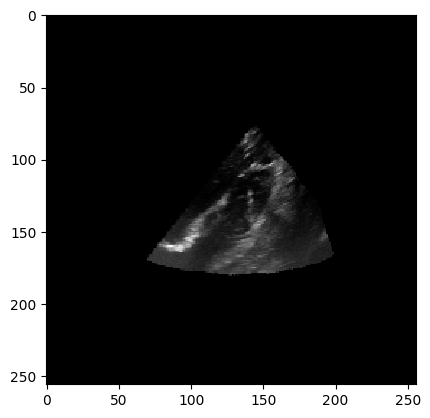

In [25]:
US = iUSDataset(image_path / iUS_file, "iUS", axis=0)
plt.imshow(US.data[:,source[1],:], cmap='gray', interpolation='nearest')

TEST

In [13]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

In [18]:
image_path + iUS_file

TypeError: unsupported operand type(s) for +: 'WindowsPath' and 'str'

In [ ]:
nii_img  = nib.load(image_path + iUS_file)
nii_data = nii_img.get_fdata()

fig, ax = plt.subplots(number_of_frames, number_of_slices,constrained_layout=True)
fig.canvas.set_window_title('4D Nifti Image')
fig.suptitle('4D_Nifti 10 slices 30 time Frames', fontsize=16)

TypeError: unsupported operand type(s) for +: 'WindowsPath' and 'str'